<center><h1>Schmidt_Matteus_HW2</h1></center>
<br>
<center><font size="4"> 

**Name:** Matteus Schmidt

**GitHub:** MatteusSchmidt

**USCID:** 3780947272

</font></center>

---

## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [443]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sci
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model


In [444]:
# !pip install openpyxl
# !pip install statsmodels

In [445]:
# !pip install pandas numpy matplotlib seaborn
# !pip freeze > ../requirements.txt

In [446]:
# Note: Jupyter env on Python 3.12

# %pip install -r ../requirements.txt

Get the Cycle Power Plant Data Set

In [447]:
path = '../data/CCPP/Folds5x2_pp.xlsx'

df = pd.read_excel(path, sheet_name='Sheet1')

# sanity check
print(df.head())

      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90


In [448]:
df = df.rename(columns={'AT':'T', 'PE':'EP'})

### (b) Exploring the data

#### i. rows and columns

In [449]:
print('Num Columns =', df.shape[1])
print('Num Rows =', df.shape[0])

Num Columns = 5
Num Rows = 9568


The columns of the dataframe represent the features of a combined cycle power plant at points it was operating at a full load. The columns are comprised four hourly averaged ambient features (Temperature (T), Exhaust Vacuum (V), Ambient Pressure (AP), and Relative Humidity (RH)) as well as the target variable, Energy Output (EP).

The rows of the dataframe represent hourly observations recorded at indiscriminate times over the period 2006-2011 from a Combined Cycle Power Plant.

#### ii. pairwise scatterplots of all the variables

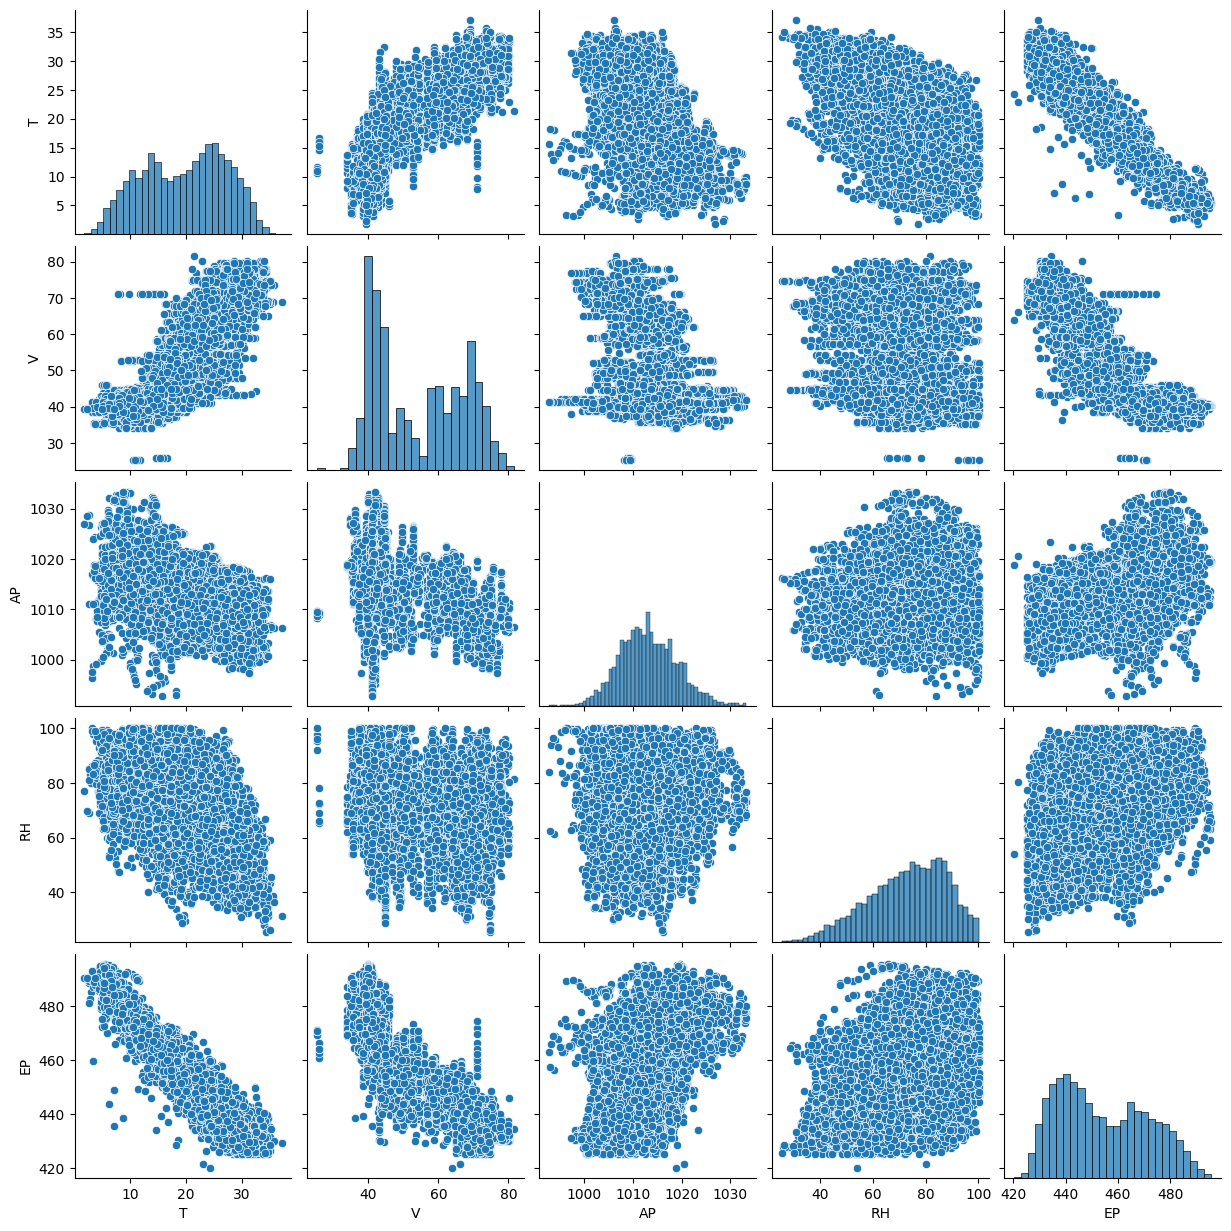

In [450]:
sns.pairplot(df)

It looks as though there are clustered Exhaust Vacuum (V) values at ~25 and ~72 that break spacial and directional patterns in the pairwise plots. These strange behaviors may be due to the fact that V is only affects and is collected from the steam turbines. As the CCPP is a comprised of steam and gas turbines, maybe there are fixed times where steam turbines have a greater or lesser affect on total output than the gas turbines. This may explain the anomolies in V at and around these values.

Energy output (EP) seems to have a negative linear relationship with Temperature (T), and a negative linear relationship, with a positive  with exhaust vacuum (V). It also has a weak postive correlation with Ambient Pressure (AP).

Temperature and Exhaust Volume seemingly trend together in the same direction, but due to non-linearity of V, and the foundational differences in the derivations of these metrics (steam vs. gas - separate entities), it is likely that they are not strongly collinear, and it should not be a problem for the OLS model.

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [451]:
array = []
for var in df.columns:
    mean = df[var].mean()
    median = df[var].median()
    f_quart = df[var].quantile(.25)
    t_quart = df[var].quantile(.75)
    IQR = t_quart - f_quart
    array.append([mean, median, f_quart, t_quart, IQR])

table = pd.DataFrame(array)
table.columns = ['Mean', 'Median','First Quartile','Third Quartile', 'IQR']
table.index = ['T', 'V', 'AP', 'RH', 'EP']
print(table)

           Mean    Median  First Quartile  Third Quartile      IQR
T     19.651231    20.345         13.5100           25.72  12.2100
V     54.305804    52.080         41.7400           66.54  24.8000
AP  1013.259078  1012.940       1009.1000         1017.26   8.1600
RH    73.308978    74.975         63.3275           84.83  21.5025
EP   454.365009   451.550        439.7500          468.43  28.6800


### (c) Simple Linear Regression

In [452]:
predictors = ['T', 'V', 'AP', 'RH']
single_regs = {}
regs_coef = {}
df['Cooks Outlier Indicator'] = 0

for predictor in predictors:
    reg = linear_model.LinearRegression()
    reg.fit(df[[predictor]], df['EP'])
    x = reg.coef_[0]
    intercept = reg.intercept_
    single_regs[predictor] = reg
    regs_coef[predictor] = x

    y_hat = reg.predict(df[[predictor]])
    residuals = df['EP'] - y_hat

    ### k = 1; df.shape[0] == df['EP'].shape[0] -> 1
    MSE = np.sum(residuals ** 2) / (df.shape[0] - 2)
    x_mean = np.mean(df[[predictor]])
    Sxx = np.sum((df[predictor] - x_mean) ** 2)
    se_hat = np.sqrt(MSE / Sxx)
    t_stat = x / se_hat

    # Cooks distance (leverage at obs i)
    h = (1/df.shape[0]) + ((df[predictor].values - x_mean)**2) / Sxx
    cooks_distance = (residuals**2 / (2 * MSE)) * (h / (1 - h)**2)

    # dummy for ease of analysis
    for i in range(df.shape[0]):
        if cooks_distance[i] > (4 / df.shape[0]):
            df.at[i, 'Cooks Outlier Indicator'] = 1
    
    print('Predictor:', predictor)
    print('Beta hat =', x)
    print('SE of Beta hat =', se_hat)
    print('t-statistic =', t_stat, '\n')



Predictor: T
Beta hat = -2.171319958517795
SE of Beta hat = 0.007443287125657965
t-statistic = -291.71519543199895 

Predictor: V
Beta hat = -1.1681351265557092
SE of Beta hat = 0.006775665282736547
t-statistic = -172.4015395996545 

Predictor: AP
Beta hat = 1.4898716733991144
SE of Beta hat = 0.0251259079325841
t-statistic = 59.29623229523181 

Predictor: RH
Beta hat = 0.4556501022629802
SE of Beta hat = 0.011006378807584875
t-statistic = 41.39872979376069 



As the sample size is large (n = 9568, converges to standard normal dist. -> influences t-stat lookup) and all |t-statistic| >= 1.96, all predictors are **statistically significant** at the **95th percent confidence level**.

In [453]:
# Checking how many outliers flagged by cooks distance > 4 / N
len(df[df['Cooks Outlier Indicator'] == 1])

1171

Outliers were flagged 1 if an observation's cooks distance was greater than 4 / N for any of the variables. There are visual anomolies within the dataset, which leads me to believe rather than outliers, due to the dimensionality of the data, there may be some points which are outliers due to miscalculated data, or simply missing covariates (bias due to missing X's inflates the importance of the single covariate, leading to incorrect outlier flagging). Therefore, cooks distance is a good way to optimize regressive techniques while removing highly influential points (supposed anomolies). The Cooks indicator incorrectly flags univariate outliers. Having determined all the features as covariates, cooks distance should be recalculated in an MLR to determine outliers in a multidimensional space, as univariate deformities and importance may differ in that space.

### (d) Multiple Regression

In [454]:
df['Cooks Outlier Indicator'] = 0

x = sm.add_constant(df[predictors])
MLR_model = sm.OLS(df['EP'], x).fit()
cooks_distance = MLR_model.get_influence().cooks_distance[0]

for i in range(df.shape[0]):
        if cooks_distance[i] > (4 / df.shape[0]):
            df.at[i, 'Cooks Outlier Indicator'] = 1

len(df[df['Cooks Outlier Indicator'] == 1])

410

As before, the number of highly influential points using Cooks in MLR has decreased from the aggreagate number of outliers from SLR due to the higher dimensional space due to overlapping effects that make some points less extreme in combination. A new regression should be run where n is equal to all obs where Cooks Outlier Indicator equals zero to account for the outliers.

In [455]:
print(MLR_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     EP   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:04:19   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

In the MLR, **all features are statistically significant to the 99th percent confidence level**. As the p values are all less than .01, the null hypothesis is rejected for all features at the 99th percent confidence level. 

### (e) 1c Compare to 1d

In [456]:
print('MLR coefficients:')
for k, v in MLR_model.params.drop('const').items():
    print('\t' + k + ':', v)

print('\nSLR coefficients:')
for k, v in regs_coef.items():
    print('\t' + k + ':', v)

MLR coefficients:
	T: -1.977513106635394
	V: -0.23391642258249845
	AP: 0.06208294378085511
	RH: -0.15805410291641303

SLR coefficients:
	T: -2.171319958517795
	V: -1.1681351265557092
	AP: 1.4898716733991144
	RH: 0.4556501022629802


In the SLRs, variables like V, AP, and RH showed much stronger effects, but once they were all included in the MLR, their coefficients decreased significantly. In MLR, individual impact to the model is smaller than the SLR models, as the SLR models are subject to omitted variable bias. MLR does a better job showing each variable’s true influence.

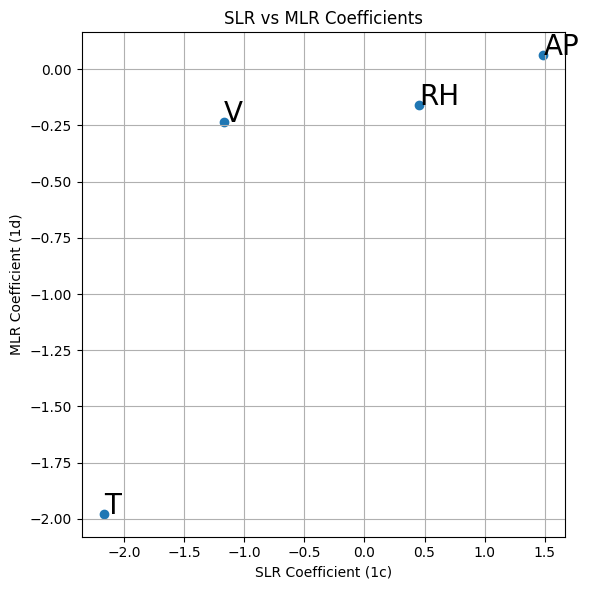

In [457]:
slr_coef = {var: single_regs[var].coef_[0] for var in predictors}
mlr_coef = MLR_model.params.drop('const')

x_vals = [slr_coef[var] for var in predictors]
y_vals = [mlr_coef[var] for var in predictors]

plt.figure(figsize=(6, 6))
plt.scatter(x_vals, y_vals)

for i, var in enumerate(predictors):
    plt.text(x_vals[i], y_vals[i], var, fontsize=20)

plt.xlabel('SLR Coefficient (1c)')
plt.ylabel('MLR Coefficient (1d)')
plt.title('SLR vs MLR Coefficients')
plt.grid(True)
plt.tight_layout()
plt.show()

### (f) Nonlinear Association

In [458]:
non_lin_models = {}

for var in df.drop(columns=['Cooks Outlier Indicator', 'EP']).columns:
    temp = pd.DataFrame()
    temp[var] = df[var]
    temp[var + '_squared'] = temp[var] ** 2
    temp[var + '_cubed'] = temp[var] ** 3

    x = sm.add_constant(temp)
    non_lin_models[var] = sm.OLS(df['EP'], x).fit()

for var, model in non_lin_models.items():
    print('Model', var, 'p-values:')
    for k, v in model.pvalues.drop('const').items():
        print('\t' + k + ':', v)
    print()


Model T p-values:
	T: 7.898147240179532e-07
	T_squared: 8.83304532647202e-73
	T_cubed: 3.652184564818124e-110

Model V p-values:
	V: 2.52658903340613e-05
	V_squared: 0.7684969443842612
	V_cubed: 0.013734885925779388

Model AP p-values:
	AP: 4.502735424099823e-17
	AP_squared: 3.6667048669126936e-17
	AP_cubed: 8.264145624205845e-18

Model RH p-values:
	RH: 0.0003772509907902755
	RH_squared: 9.395429589535408e-06
	RH_cubed: 1.4402785078902226e-05



All cubic terms are statistically signficicant as |t-stat| >= 1.96. The same goes for all quadratic tems except for Exhaust Vacuum squared (V_squared). This is enough to conclude that all covariates have non-linear relationships with energy output (EP).

### (g) Interactions of Predictors

In [459]:
# sanity check
# print(df.head(), '\n')
# print(len(df[df['Cooks Outlier Indicator'] == 1]))

In [460]:
for i, col in enumerate(df[predictors].columns):
    for j in range(i, len(predictors)):
        if i == j:
            continue
        name = col + '_' + df[predictors].columns[j]
        df[name] = df[col] * df[df[predictors].columns[j]]

In [461]:
# sanity check
print(df.head())

       T      V       AP     RH      EP  Cooks Outlier Indicator        T_V  \
0  14.96  41.76  1024.07  73.17  463.26                        0   624.7296   
1  25.18  62.96  1020.04  59.08  444.37                        0  1585.3328   
2   5.11  39.40  1012.16  92.14  488.56                        0   201.3340   
3  20.86  57.32  1010.24  76.64  446.48                        0  1195.6952   
4  10.82  37.50  1009.23  96.62  473.90                        0   405.7500   

         T_AP       T_RH        V_AP       V_RH       AP_RH  
0  15320.0872  1094.6232  42765.1632  3055.5792  74931.2019  
1  25684.6072  1487.6344  64221.7184  3719.6768  60263.9632  
2   5172.1376   470.8354  39879.1040  3630.3160  93260.4224  
3  21073.6064  1598.7104  57906.9568  4393.0048  77424.7936  
4  10919.8686  1045.4284  37846.1250  3623.2500  97511.8026  


In [462]:
x = sm.add_constant(df.drop(columns=['EP', 'Cooks Outlier Indicator']))
interactions_model = sm.OLS(df['EP'], x).fit()

print('Interaction MLR p-values:')
for k, v in interactions_model.pvalues.drop('const').to_dict().items():
    print('\t' + k + ':', v)

Interaction MLR p-values:
	T: 0.06701872693326134
	V: 1.3712507866924252e-08
	AP: 0.047357317537635286
	RH: 0.04225213328698191
	T_V: 3.3333576161506e-117
	T_AP: 0.4520508833702128
	T_RH: 1.2169442667257787e-10
	V_AP: 2.8770258994522485e-07
	V_RH: 0.08619365980389056
	AP_RH: 0.0336055726221921


Interaction terms between: Temperature and Exhaust Vacuum; Temperature and Relative Humidity; Exhaust Vacuum and Ambient Pressure; Ambient Pressure and Relative Humidity are all statistically significant.

Heuristically, these interaction terms make sense, especially those with exhaust vacuum as they are interactions between outputs from the steam (EV) and gas engine.

Relative Humidity joint with Ambient pressure, as well as Relative Humidity joint with temperature, affect air density when entering the gas combustion chamber, affecting output.

### (h) Improvement

In [463]:
for col in df[predictors].columns:
    df[col + '_squared'] = df[col] ** 2
    df[col + '_cubed'] = df[col] ** 3

print(df.columns)

Index(['T', 'V', 'AP', 'RH', 'EP', 'Cooks Outlier Indicator', 'T_V', 'T_AP',
       'T_RH', 'V_AP', 'V_RH', 'AP_RH', 'T_squared', 'T_cubed', 'V_squared',
       'V_cubed', 'AP_squared', 'AP_cubed', 'RH_squared', 'RH_cubed'],
      dtype='object')


In [464]:
train = df.sample(frac=.7,random_state=50)
test = df.drop(train.index)

baseline_columns = []
for col in df.columns:
    if not col.endswith('_cubed'):
        baseline_columns.append(col)

#### Baseline Model

In [465]:
x = sm.add_constant(train[baseline_columns].drop(columns=['EP', 'Cooks Outlier Indicator']))
baseline_first_model = sm.OLS(train['EP'], x).fit()

print('First go Baseline MLR p-values:')
for k, v in baseline_first_model.pvalues.drop('const').to_dict().items():
    print('\t' + k + ':', v)

First go Baseline MLR p-values:
	T: 0.7709438768091665
	V: 0.0006906512999544744
	AP: 3.424809549958045e-08
	RH: 7.571699774747238e-06
	T_V: 2.186405642214047e-06
	T_AP: 0.6591351193378016
	T_RH: 7.062884501342673e-05
	V_AP: 0.001569502664036421
	V_RH: 0.10765052090088095
	AP_RH: 1.5366898924091927e-05
	T_squared: 3.512426170450868e-05
	V_squared: 0.07065286045911456
	AP_squared: 2.8718624549939324e-08
	RH_squared: 9.356778314328334e-12


'T', 'T_AP', 'V_AP', 'V_RH', 'V_squared' all exceed the 95 percent confidence level, therefore all except Temperature (T) are dropped.

In [466]:
insignificant_columns = ['T_AP', 'V_AP', 'V_RH', 'V_squared', 'EP', 'Cooks Outlier Indicator']
x = sm.add_constant(train[baseline_columns].drop(columns=insignificant_columns))
baseline_test_model = sm.OLS(train['EP'], x).fit()

print('Second go Baseline MLR p-values:')
for k, v in baseline_test_model.pvalues.drop('const').to_dict().items():
    print('\t' + k + ':', v)

Second go Baseline MLR p-values:
	T: 4.43683041161696e-134
	V: 2.333971218244465e-44
	AP: 5.9101233820083e-21
	RH: 5.008590840952789e-14
	T_V: 3.203130392528627e-07
	T_RH: 1.9780851577490544e-12
	AP_RH: 2.923313894616088e-13
	T_squared: 1.8643748712367745e-18
	AP_squared: 5.936672010856864e-20
	RH_squared: 1.726081411333549e-14


In [467]:
x_test = sm.add_constant(test[baseline_columns].drop(columns=insignificant_columns))
y_train_pred = baseline_test_model.predict(x)
y_test_pred = baseline_test_model.predict(x_test)

train_mse = sci.metrics.mean_squared_error(train['EP'], y_train_pred)
test_mse = sci.metrics.mean_squared_error(test['EP'], y_test_pred)

print('Baseline Model:')
print('\tTraining MSE:', train_mse)
print('\tTest MSE:', test_mse)

Baseline Model:
	Training MSE: 17.902561480273025
	Test MSE: 18.73861551987049


#### Personal Model

In [468]:
insignificant_columns.append('V_cubed')
insignificant_columns.append('RH_cubed')
insignificant_columns.append('T_V')

x = sm.add_constant(train.drop(columns=insignificant_columns))
personal_test_model = sm.OLS(train['EP'], x).fit()
cooks_distance = personal_test_model.get_influence().cooks_distance[0]

for i in range(train.shape[0]):
        if cooks_distance[i] > (4 / train.shape[0]):
            df.at[i, 'Cooks Outlier Indicator'] = 1
        else:
             df.at[i, 'Cooks Outlier Indicator'] = 0

print('Personal model MLR p-values:')
for k, v in personal_test_model.pvalues.drop('const').to_dict().items():
    print('\t' + k + ':', v)

Personal model MLR p-values:
	T: 7.601724854904148e-25
	V: 1.8892092325665245e-196
	AP: 6.553789189531223e-21
	RH: 2.0606262020018043e-17
	T_RH: 5.006338034424986e-08
	AP_RH: 1.1580260799543645e-16
	T_squared: 7.528687390931363e-07
	T_cubed: 1.4404764237090647e-19
	AP_squared: 1.1581568554706572e-22
	AP_cubed: 1.6140483515292174e-22
	RH_squared: 3.2315619709384737e-16


In [469]:
x_test = sm.add_constant(test.drop(columns=insignificant_columns))
y_train_pred = personal_test_model.predict(x)
y_test_pred = personal_test_model.predict(x_test)

train_mse = sci.metrics.mean_squared_error(train['EP'], y_train_pred)
test_mse = sci.metrics.mean_squared_error(test['EP'], y_test_pred)

print('Personal Model:')
print('\tTraining MSE:', train_mse)
print('\tTest MSE:', test_mse)

Personal Model:
	Training MSE: 17.75206176652145
	Test MSE: 18.49711770039893


#### Model with Cooks Distance outliers removed

In [470]:
cooks_train = train[train['Cooks Outlier Indicator'] == 0]
x = sm.add_constant(cooks_train.drop(columns=insignificant_columns))
cooks_model = sm.OLS(cooks_train['EP'], x).fit()

print('Cooks model MLR p-values:')
for k, v in cooks_model.pvalues.drop('const').to_dict().items():
    print('\t' + k + ':', v)

Cooks model MLR p-values:
	T: 8.007053692275113e-24
	V: 2.798581381728231e-217
	AP: 1.0144960564443795e-20
	RH: 3.178251057043903e-16
	T_RH: 1.5011750017826807e-07
	AP_RH: 1.5238053691868357e-15
	T_squared: 8.971979705259784e-09
	T_cubed: 8.35245502050076e-21
	AP_squared: 1.0555004437977421e-22
	AP_cubed: 1.2238642202461323e-22
	RH_squared: 8.735105864883904e-17


In [471]:
x_test = sm.add_constant(test.drop(columns=insignificant_columns))
y_train_pred = cooks_model.predict(x)
y_test_pred = cooks_model.predict(x_test)

train_mse = sci.metrics.mean_squared_error(cooks_train['EP'], y_train_pred)
test_mse = sci.metrics.mean_squared_error(test['EP'], y_test_pred)

print('Personal Cooks Model:')
print('\tTraining MSE:', train_mse)
print('\tTest MSE:', test_mse)

Personal Cooks Model:
	Training MSE: 14.024638959987987
	Test MSE: 18.510035989702555


While the Cook’s model had the lowest in-sample MSE, the personal model performed slightly better out-of-sample, suggesting a small generalization advantage without substantial overfitting.

### (i) KNN

#### Raw

In [472]:
k_list = list(range(1,101))
test_mse = {}
train_mse = {}

for k in k_list:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(train[predictors], train['EP'])

    y_train_pred = model.predict(train[predictors])
    y_test_pred = model.predict(test[predictors])

    train_mse[k] = sci.metrics.mean_squared_error(train['EP'], y_train_pred)
    test_mse[k] = sci.metrics.mean_squared_error(test['EP'], y_test_pred)

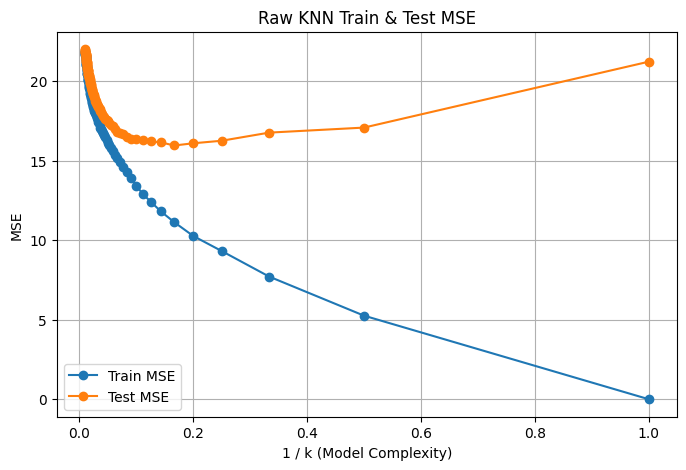

In [473]:
inv_k = [1/k for k in k_list]
train_errors = [train_mse[k] for k in k_list]
test_errors = [test_mse[k] for k in k_list]

plt.figure(figsize=(8, 5))
plt.plot(inv_k, train_errors, marker='o', label='Train MSE')
plt.plot(inv_k, test_errors, marker='o', label='Test MSE')
plt.xlabel('1 / k (Model Complexity)')
plt.ylabel('MSE')
plt.title('Raw KNN Train & Test MSE')
plt.legend()
plt.grid(True)

In [474]:
print('Raw KNN Regression metrics')
print('\tBest K:', min(test_mse, key=test_mse.get))
print('\tCorresponding test MSE:', test_mse[min(test_mse, key=test_mse.get)])

Raw KNN Regression metrics
	Best K: 6
	Corresponding test MSE: 15.950369457994592


#### Standardized

In [475]:
scaler = sci.preprocessing.StandardScaler()
train_scaled = scaler.fit_transform(train[predictors])
test_scaled = scaler.transform(test[predictors])

for k in k_list:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(train_scaled, train['EP'])

    y_train_pred = model.predict(train_scaled)
    y_test_pred = model.predict(test_scaled)

    train_mse[k] = sci.metrics.mean_squared_error(train['EP'], y_train_pred)
    test_mse[k] = sci.metrics.mean_squared_error(test['EP'], y_test_pred)

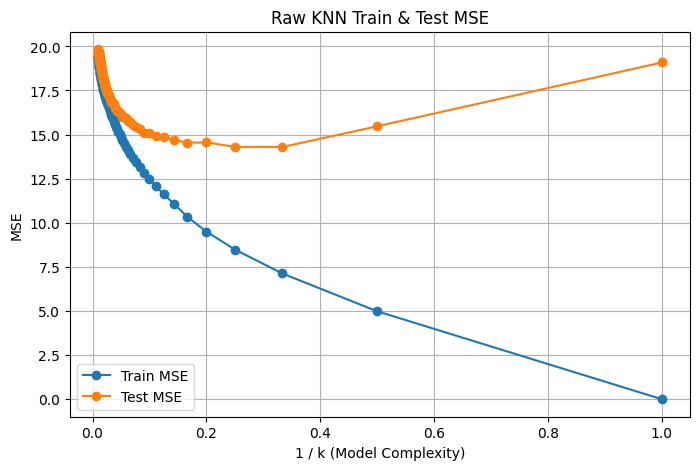

In [ ]:
inv_k = [1/k for k in k_list]
train_errors = [train_mse[k] for k in k_list]
test_errors = [test_mse[k] for k in k_list]

plt.figure(figsize=(8, 5))
plt.plot(inv_k, train_errors, marker='o', label='Train MSE')
plt.plot(inv_k, test_errors, marker='o', label='Test MSE')
plt.xlabel('1 / k (Model Complexity)')
plt.ylabel('MSE')
plt.title('Standardized KNN Train & Test MSE')
plt.legend()
plt.grid(True)

In [477]:
print('Standardized KNN Regression metrics')
print('\tBest K:', min(test_mse, key=test_mse.get))
print('\tCorresponding test MSE:', test_mse[min(test_mse, key=test_mse.get)])

Standardized KNN Regression metrics
	Best K: 3
	Corresponding test MSE: 14.298274394115369


### (j ) Compare KNN and Linear

The best performing KNN regression model was the standardized model with k=3 which had a test MSE of 14.298.

The best performing Linear Regression model was that of the Personal model with quadratic, cubic, and interaction terms, with a test MSE of 18.497.

The KNN standardized model outperformed all other models, especially the linear models. This is due to the fact that KNN regressions are non-parametric in nature. Therefore, it does not assume linearity between covariates as OLS inherently does. This leads to OLS MSEs being inflated due to underfitting. It was forcing the nature of the data to conform to a linear relationship.

However, as we saw in 1.f, all four hourly ambient features were interpreted to have statistically significant interaction, and higher order, terms. To properly account for the significance of these features, they must be included in the OLS regression. However, by doing so, we overpopulated the feature space, resulting in highly complex linear model, introducing high degrees of multicollinearity. 

KNN regression however, does not suffer from the same downfalls. It captures nonlinear relationships and interaction effects implicitly through proximity in the feature space, without requiring explicit modeling or expansion of features, making it robust in low-dimensional inference, avoiding the collinearity inherent to the OLS model.

KNN balances the bias–variance tradeoff by adapting to local patterns in the data. In this case, the true relationship between the predictors and energy output appeared nonlinear with interaction effects. While linear models like OLS are low-variance but high-bias when misspecified, KNN offered lower bias by flexibly capturing these patterns. With only the original feature set and proper scaling, KNN avoided overfitting and achieved the best out-of-sample performance.

## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

Flexible methods would generally perform better than inflexible methods.

With such a large N, relationships between variables are often complex and regional. Flexible methods allow models to learn these complex relationships and patterns without overfitting. Further, flexible methods function the best with a small p, as they are not subject to the curse of dimensionality as with a large p.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

Flexible methods would generally perform worse than inflexible methods.

Flexible methods would be subject to the curse of dimensionality. As the dimension of the feature space increases, localized patterns, movements, and momentums are harder to pinpoint. One of the reasons for this in the case of KNN is that the distance metric between points in a higher dimensional space become much larger, making it harder for neighbors to be significant predictors in a sparse space. Variance subsequently increases dramatically, leading to model overfitting.

### (c) The relationship between the predictors and response is highly non-linear.

Flexible methods would generally perform better than inflexible methods.

As we've observed from this dataset, when predictors are non-linear in nature to the target, flexible methods allow for complex regional and non-linear patterns be learned. This generally makes them more precise than inflexible methods in this case.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

Flexible methods would generally perform worse than inflexible methods.

With high variance, flexible methods are more likely to overfit random noise in the data, mistaking it for signal. In contrast, inflexible methods such as multiple linear regression (OLS) are less sensitive to noise because they assume a simple functional form by brute force minimizing residuals. This allows for simple patterns to form, and for the model to generalize better in noisy settings by prioritizing bias over variance.

## 3. ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

In [479]:
table = [
    [0,3,0],
    [2,0,0],
    [0,1,3],
    [0,1,2],
    [-1,0,1],
    [1,1,1]

]

def euc_dist_to_origin(obs):
    return np.sqrt((obs[0] ** 2) + (obs[1] ** 2) + (obs[2] ** 2))

for i, item in enumerate(table):
    dist = euc_dist_to_origin(item)
    print('Observation', i + 1, 'Euclidean dist. =', dist)

Observation 1 Euclidean dist. = 3.0
Observation 2 Euclidean dist. = 2.0
Observation 3 Euclidean dist. = 3.1622776601683795
Observation 4 Euclidean dist. = 2.23606797749979
Observation 5 Euclidean dist. = 1.4142135623730951
Observation 6 Euclidean dist. = 1.7320508075688772


### (b) What is our prediction with K = 1? Why?

The classification for the origin point with a k = 1 KNN would be green. This is because with K = 1, the smallest euc. dist. to the origin (inference point) is observation 5 which is classified as green. Majority polling from a single reference point -> matches the classification of the reference point.

### (c) What is our prediction with K = 3? Why?

The classification for the origin point with a k = 3 KNN would be red. This is because with k = 3, the three smallest euc. distances to the origin (inference point) are observation 5, 6, and 2, which are classified as green, red, and red, respectively. Majority polling from a three reference points -> matches the classification of the reference points which occur most frequently (which is red).

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

If the Bayes decision boundary is highly non-linear, the best value for k would be small. As k increases, the decision boundary smooths, as more and more classifications are taken into account, making local differences moot. If the decision boundary is highly nonlinear, it must be influenced greatly by local observations, meaning a small k is necessary to more precicely predict the decision boundary using KNN classification.

---

# References

**Markdown Guide**: https://www.markdownguide.org/cheat-sheet/

**Pandas Excel**: https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html

**Sci-Kit OLS**: https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares

**Cooks Distance Formulae (SLR)**: https://en.wikipedia.org/wiki/Cook%27s_distance
- MLR: https://www.statology.org/cooks-distance-python/
- also piazza question @49 

**KNN Regression**: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor